In [1]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import check_random_state

train_samples = 5_000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation].astype(np.float32)
y = y[permutation].astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=1000
)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.reshape(X_train, newshape=[X_train.shape[0], 1, 28, 28])
X_test = np.reshape(X_test, newshape=[X_test.shape[0], 1, 28, 28])

ohe = OneHotEncoder()
ohe.fit(y_train.reshape(-1, 1))
# y_train = ohe.transform(y_train.reshape(-1, 1))
# y_test = ohe.transform(y_test.reshape(-1, 1))

OneHotEncoder()

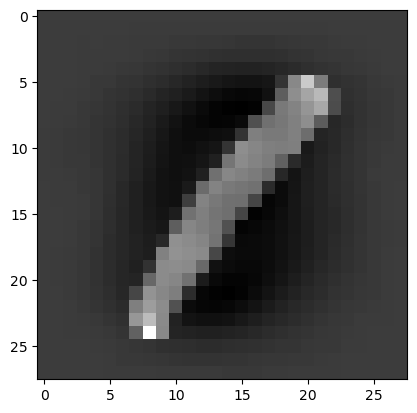

In [2]:
from matplotlib import pyplot as plt

img = X_train[6].reshape([28, 28, 1]).copy()
plt.imshow(img, cmap='gray')

In [3]:
from lab1.numpy_src.layers import Conv2D
from lab1.numpy_src.loss import CrossEntropyLoss
from lab1.numpy_src.optim import AdaSmooth
from lab1.numpy_src.models.alexnet import AlexNet

model = AlexNet()

In [4]:
model.train()
out = model.forward(np.random.random((1, 3, 227, 227)))
out

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]])

In [6]:
cel = CrossEntropyLoss()
crit = AdaSmooth(model.layers, lr=0.0005)

In [8]:
from lab1.numpy_src.data import Dataset, Dataloader

dataset_train = Dataset(data=X_train, target=y_train)
dataloader_train = Dataloader(dataset=dataset_train, batch_size=8, shuffle=True)

dataset_test = Dataset(data=X_test, target=y_test)
dataloader_test = Dataloader(dataset=dataset_test, batch_size=8)

In [9]:
from tqdm import tqdm
import cv2

def accuracy(pred, true):
    pred_int = np.argmax(pred, axis=1)
    return np.sum(pred_int == true) / pred.shape[0]


def convert_img(imgs):
    new_imgs = list()
    for img in imgs:
        img = img.reshape((28, 28, 1))
        img = np.concatenate([img, img, img], axis=2)
        img = np.array(cv2.resize(img, dsize=(227, 227)), dtype='float64')
        img = img.reshape(3, 227, 227)
        new_imgs.append(np.expand_dims(img, axis=0))
    return np.concatenate(new_imgs, axis=0)


def train_epoch(epoch: int):
    model.train()
    full_loss = 0
    with tqdm(total=len(dataloader_train)) as t:
        for j, samples in enumerate(dataloader_train):
            data, targets = samples
            crit.zero_grad()
            data = convert_img(data)
            out = model.forward(data / 255)
            lbl_ohe = np.zeros_like(out)
            lbl_ohe[list(range(out.shape[0])), targets] = 1
            loss, grad = cel(out, targets)
            full_loss += loss
            model.backward(grad)
            crit.update()
            t.update(1)
            t.set_description(f'Train epoch: {epoch} | Loss: {full_loss / (j + 1)}')


def evaluate(epoch: int):
    acc = 0
    model.eval()
    with tqdm(total=len(dataloader_test)) as t:
        for j, samples in enumerate(dataloader_test):
            data, targets = samples
            crit.zero_grad()
            converted = convert_img(data)
            # data = data.astype('float64')
            # converted = data
            out = model.forward(converted / 255)
            acc += accuracy(out, targets)
            t.update(1)
            t.set_description(f'Test epoch: {epoch} | Accuracy {acc / (j + 1)}')


for i in range(2):
    train_epoch(i + 1)
    evaluate(i + 1)

Train epoch: 1 | Loss: 1.3407220876930872: 100%|██████████| 625/625 [1:20:36<00:00,  7.74s/it]
Test epoch: 1 | Accuracy 0.805: 100%|██████████| 125/125 [01:30<00:00,  1.38it/s]             
Train epoch: 2 | Loss: 1.0409938222221986:   1%|          | 4/625 [00:44<1:54:19, 11.05s/it]


KeyboardInterrupt: 

In [ ]:
import numpy as np

test_arr = np.random.randn(1, 1, 28, 28)
grad_arr = np.random.randn(1, 3, 28, 28)

np_conv = Conv2D(name='conv_test', in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1)
np_conv.forward(test_arr)
np_grad = np_conv.backward(grad_arr)

from torch import nn
import torch

torch_conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1)
torch_out = torch_conv(torch.autograd.Variable(torch.tensor(test_arr, dtype=torch.float32, requires_grad=True)))
loss = torch_out - torch.zeros_like(torch_out)
loss.backward()
np_grad.shape, torch_out.grad

In [ ]:
k = 465

model.eval()
# print(convert_img(X_test[k]).shape)
out = model.forward(convert_img(X_test[k]).astype('float64') / 255)
out.argmax(), y_test[k]